# Изучение закономерностей, определяющих успешность игр

**Цель:** выявить факторы, которые определяют успех компьютерной игры, что позволит прогнозировать популярность продукта и планировать рекламные кампании.

**Входные данные** — таблица с данными о продажах игр, оценках пользователей и экспертов, жанрах и информация о платформах. 

**План:**
1.Загрузка данных

2.Предобработка данных

3.Исследовательский анализ данных

4.Составление портрета пользователя каждого региона

5.Проверка гипотез

6.Общий вывод

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.patches as patches

## Загрузка данных

Импортируем файл с данными и изучим общую информацию

In [2]:
datasets_games = pd.read_csv('/datasets/games.csv')

In [3]:
datasets_games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


## Предобработка данных

### Названия столбцов

**Переименуем названия столбцов**

In [4]:
datasets_games.shape

(16715, 11)

In [5]:
datasets_games = datasets_games.rename(columns={'Name':'name','Platform':'platform','Year_of_Release':'year_of_release', 'Genre':'genre', 'NA_sales':'na_sales', 'EU_sales':'eu_sales', 'JP_sales':'jp_sales','Other_sales':'other_sales','Critic_Score':'critic_score','User_Score':'user_score','Rating':'rating'})

In [6]:
datasets_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Проверка дубликатов и изменение типа данных столбцов

**Проверим есть ли в таблице дубликаты**

In [7]:
datasets_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [8]:
datasets_games.duplicated().sum()

0

Явные дубликаты отсутствуют

In [9]:
duplicates = datasets_games.duplicated(subset=['name', 'platform', 'year_of_release']).sum()
duplicates

2

Неявных дубликата 2. Проверяли  одновременно по имени, платформе и году релиза. Посмотрим что это за строки.

In [10]:
duplicates = datasets_games.duplicated(subset=['name', 'platform', 'year_of_release'], keep=False)

# Применяем маску duplicates к исходному DataFrame, чтобы получить только дубликаты
duplicated_rows = datasets_games[duplicates]

# Теперь duplicated_rows - это DataFrame, содержащий только дублирующиеся строки
print(duplicated_rows)


                name platform  year_of_release   genre  na_sales  eu_sales  \
604    Madden NFL 13      PS3           2012.0  Sports      2.11      0.22   
659              NaN      GEN           1993.0     NaN      1.78      0.53   
14244            NaN      GEN           1993.0     NaN      0.00      0.00   
16230  Madden NFL 13      PS3           2012.0  Sports      0.00      0.01   

       jp_sales  other_sales  critic_score user_score rating  
604        0.00         0.23          83.0        5.5      E  
659        0.00         0.08           NaN        NaN    NaN  
14244      0.03         0.00           NaN        NaN    NaN  
16230      0.00         0.00          83.0        5.5      E  


Две пары дубликатов, но есть некоторые различия в других столбцах, таких как na_sales, eu_sales, jp_sales, other_sales, critic_score, user_score, rating и total_sales.

Madden NFL 13 на PS3 в 2012 году: Эти строки идентичны по указанным столбцам, но имеют разные значения продаж. Это может быть связано с тем, что данные были собраны в разное время или от разных источников.Важность информации о продажах не критична для  анализа, мы можете просто удалить дубликаты, оставив только одну строку с наибольшими продажами

NaN на GEN в 1993 году: Эти строки идентичны по указанным столбцам, но name и genre неизвестны, а critic_score и user_score равны -1, что, является заполнителем для пропущенных данных. Мы не можем определить, какие игры представлены этими строками, их удаление может быть одним из вариантов, чтобы не искажать результаты нашего анализа.

In [11]:
datasets_games = datasets_games.drop_duplicates(subset=['name', 'platform', 'year_of_release'])

In [12]:
datasets_games.shape[0]

16713

Итого после удаления 2-х дубликатов осталось 16 713 строк

**Изменим типа данных столбцов**

Необходимо привести столбец year_of_release из float64 в int для повышение читаемости, чтобы избавиться от десятичных знаков.

In [13]:
datasets_games['year_of_release'] = datasets_games['year_of_release'].astype('Int64')

### Обработка пропусков в таблице

**Определим что значит 'tbd' в столбце с оценкой пользователей.**

In [14]:
datasets_games['user_score'].value_counts() 

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
0.5       2
0.9       2
2.3       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

TBD в столбце оценка пользователей это - рейтинг еще неизвестен. Такие значения нам не нужны, так как по ним анализ мы не сможем сделать. Смело заменим их на Nan.  

In [15]:
datasets_games['user_score'] = pd.to_numeric(datasets_games['user_score'], errors='coerce')

In [16]:
datasets_games.head(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN


**Обработаем остальные пропуски в таблице**

In [17]:
b = datasets_games.isna().sum()
b

name                  1
platform              0
year_of_release     269
genre                 1
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8577
user_score         9124
rating             6765
dtype: int64

**Пропуски в данных** могли возникнуть по различным причинам, и обычно связаны с особенностями сбора или обработки данных. 

Пропуски в **столбцах critic_score, user_score** могут быть обусловлены следующими причинами:

1. **Игра еще не была оценена:** Некоторые игры могут быть слишком новыми или малоизвестными, чтобы получить достаточное количество оценок от пользователей или критиков.

2. **Политика приватности и Правила оценивания:** Некоторые данные могут быть недоступны из-за политики конфиденциальности или правил оценивания различных платформ. Например, если игра имеет ограничение по возрасту и не позволяет младшим пользователям оставлять оценки, это может повлиять на общее количество оценок.

3. **Ошибки в данных:** Пропуски могут быть результатом ошибок при сборе, обработке или загрузке данных. Это может случиться, например, при ошибке в программе сбора данных или если данные были повреждены или потеряны при передаче или хранении.

**Пропуски в данных в стобце рейтинга** пропуски в этом столбце могут быть связаны не с ошибкой в данных, а с тем, что игры выпускаются не только для Северной Америки или Европы.

**Пропуски в данных в стобце года релиза игры**, могут быть связаны с несколькими причинами:

1. **Ошибки при сборе данных:** Пропуски могут возникнуть при сборе данных из-за технических ошибок, ошибок ввода или пропущенной информации.

2. **Неизвестный год релиза:** В некоторых случаях, год релиза игры может быть неизвестен. Это может быть связано с тем, что игра еще не была выпущена на момент сбора данных, или же информация о годе релиза не была обнародована.

3. **Несколько дат релиза:** Игры часто выпускаются в разное время в разных регионах мира. Это может создать неоднозначность при назначении конкретного года релиза.

4. **Релизы обновлений или новых версий игры:** Иногда игры получают обновления или выпускаются новые версии, что может внести путаницу в определение исходного года релиза.

**Пропуски в столбцах 'name' и 'genre'** могут быть связаны с различными причинами, но скорее всего это ошибки при сборе данных: Пропуски могут возникать из-за технических проблем, ошибок при вводе данных или неполного сбора информации.

In [18]:
a = datasets_games.shape[0]
a

16713

Проверим при удалении этих значений, сколько процентов данных у нас останется

In [19]:
percentage_absences_critic_score = round(100-b['critic_score']/a*100)
percentage_absences_critic_score

49

In [20]:
percentage_absences_user_score = round(100-b['user_score']/a*100)
percentage_absences_user_score

45

In [21]:
percentage_absences_rating = round(100-b['rating']/a*100)
percentage_absences_rating

60

In [22]:
percentage_absences_year_of_release = round(100-b['year_of_release']/a*100)
percentage_absences_year_of_release

98

В данных year_of_release мы потеряем лишь 2 процента данных, можем смело удалить их. 

Поскольку мы рискуем потерять более 10 процентов данных в данных critic_score, user_score, rating не стоит их удалять. Вместо этого, лучше заменить пропуски на подходящие значения.

In [23]:
# Комментарий ревьюера
temp = datasets_games.copy()
display(pd.DataFrame(round((temp.isna().mean()*100),2), columns=['NaNs, %'])
        .style.format( '{:.2f}').background_gradient('coolwarm'))

,"NaNs, %"
name,0.01
platform,0.00
year_of_release,1.61
genre,0.01
na_sales,0.00
eu_sales,0.00
jp_sales,0.00
other_sales,0.00
critic_score,51.32
user_score,54.59


У нас имеются пропуски по столбцу name и genre удалим их.

Там где неизвестен год релиза удалим,  так как весь анализ строится на динамике по годам.
В таблице так же есть пропуски по столбцам:

critic_score       8578

user_score         9125

rating             6766

Пропущенные значения составляют большую часть данных, их заполнение медианой или средним может исказить распределение данных. Поэтому лучше заполнить critic_score и user_score (-1). -1 может быть легко идентифицирован как "отсутствующее" или "неизвестное" значение, особенно в данных, где все остальные значения являются положительными.

rating заполним словом unknown. Может пригодится для отрисовки графика


In [24]:
# Проверим минимальное значение, чтоб понимать какое значение ставить на месте пропусков в оценках критиков
datasets_games['critic_score'].min()

13.0

In [25]:
# Проверим минимальное значение, чтоб понимать какое значение ставить на месте пропусков в оценках пользователей
datasets_games['user_score'].min()

0.0

In [26]:
datasets_games['critic_score'] = datasets_games['critic_score'].fillna(-1)
datasets_games['user_score'] = datasets_games['user_score'].fillna(-1)
datasets_games['rating'] = datasets_games['rating'].fillna('unknown')

In [27]:
datasets_games = datasets_games.dropna(subset=['year_of_release','genre','name'])

In [28]:
datasets_games.isna().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

### Cуммарные продажи во всех регионах

**Посчитаем суммарные продажи во всех регионах**

In [29]:
datasets_games['total_sales'] = datasets_games['na_sales'] + datasets_games['eu_sales'] + datasets_games['jp_sales'] + datasets_games['other_sales']

In [30]:
datasets_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,unknown,31.38


Теперь у нас имеется столбец с общим объемом продаж по регионам. Это облегчит наш дальнейший анализ.

In [31]:
# Комментарий ревьюера
# Посмотрим, что осталось
temp = datasets_games.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().mean()*100,2),'%') 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  Int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     16443 non-null  float64
 9   user_score       16443 non-null  float64
 10  rating           16443 non-null  object 
 11  total_sales      16443 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.6+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
n

## Исследовательский анализ данных

### Выпуск игр в разные годы

**Посчитаем выпуски игр  в разные годы и построим график по количеству выпусков игр**

In [32]:
games_per_year = datasets_games.groupby('year_of_release')['name'].count()

In [33]:
games_per_year

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     652
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64

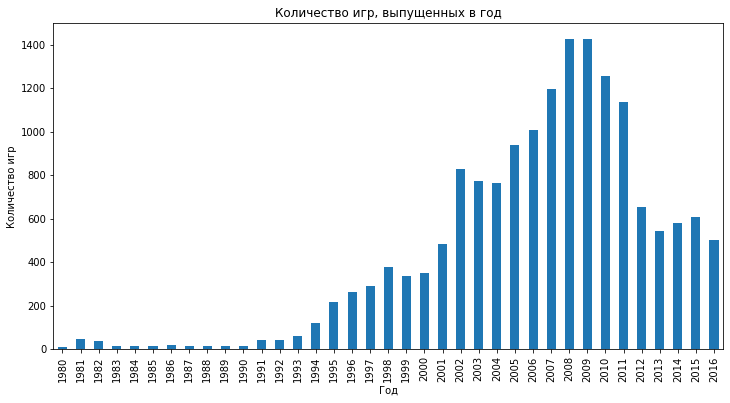

In [34]:
games_per_year.plot(kind='bar', figsize=(12,6))
plt.title('Количество игр, выпущенных в год')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.show()


На основе представленных данных, мы видим, что количество выпускаемых игр существенно увеличивается с каждым годом, начиная примерно с 1993 года, достигает пика в 2008-2009 годах, а затем немного снижается.

**Данные по всем периодам не важны. Нам нужен актуальный анализ, соответственно лучше базироваться на свежей информации, так как мы хотим сосредоточиться на самых последних тенденциях и изменениях в игровой индустрии.**

### Изменение продаж игр по годам

Посмотрим, как менялись продажи по платформам, и выберем платформы с наибольшими суммарными продажами. После этого построим распределение по годам. Это поможет ответить на вопрос, за какой характерный срок появляются новые и исчезают старые платформы. 

In [35]:
platform_sales = datasets_games.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()
#сгруппировали данные для получения количества продаж по году и платформе

In [36]:
platform_sales

,platform,year_of_release,total_sales
0,2600,1980,11.38
1,2600,1981,35.68
2,2600,1982,28.88
3,2600,1983,5.84
4,2600,1984,0.27
...,...,...,...
233,XB,2008,0.18
234,XOne,2013,18.96
235,XOne,2014,54.07
236,XOne,2015,60.14


In [37]:
top_platforms = platform_sales.groupby('platform')['total_sales'].sum().nlargest(5).index
top_platforms# выбрали топовые платформы (у которых были наибольшие продажи)

Index(['PS2', 'X360', 'PS3', 'Wii', 'DS'], dtype='object', name='platform')

In [38]:
# Отфильтруем данные только по топ-5 платформам
top_platforms_sales = platform_sales[platform_sales['platform'].isin(top_platforms)]
top_platforms_sales.head(5)

,platform,year_of_release,total_sales
25,DS,1985,0.02
26,DS,2004,17.27
27,DS,2005,130.14
28,DS,2006,119.81
29,DS,2007,146.94


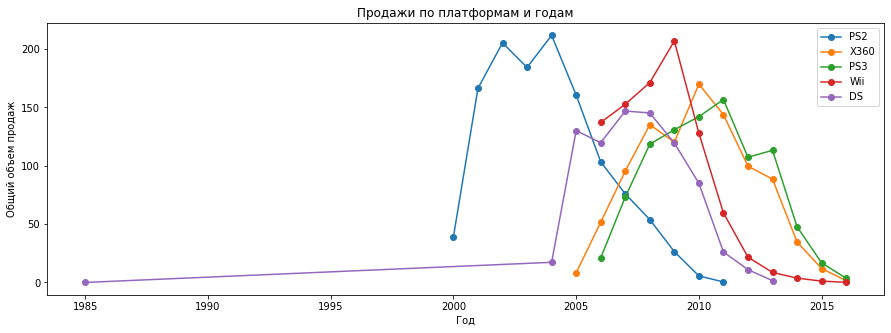

In [39]:
plt.figure(figsize=(15,5))

# Построим распределение продаж по годам для каждой из топ-5 платформ

for platform in top_platforms:
    plt.plot(
        top_platforms_sales[top_platforms_sales['platform'] == platform]['year_of_release'],
        top_platforms_sales[top_platforms_sales['platform'] == platform]['total_sales'],
        '-o',
        label=platform,
    )

plt.title('Продажи по платформам и годам')
plt.xlabel('Год')
plt.ylabel('Общий объем продаж')
plt.legend()
plt.show()

Проверим действительно ли была платформа DS в 1985. Для этого посмотрим ее продажи по годам

In [40]:
# Продажи игр на платформе DS в 1985
er = top_platforms_sales[top_platforms_sales['year_of_release'] == 1985]
er

,platform,year_of_release,total_sales
25,DS,1985,0.02


Была всего одна продажа. Посмотрим распределение продаж по годам по платформе DS

In [41]:
top_platforms_ds_sales = top_platforms_sales[top_platforms_sales['platform']=='DS']
top_platforms_ds_sales

,platform,year_of_release,total_sales
25,DS,1985,0.02
26,DS,2004,17.27
27,DS,2005,130.14
28,DS,2006,119.81
29,DS,2007,146.94
30,DS,2008,145.31
31,DS,2009,119.54
32,DS,2010,85.02
33,DS,2011,26.18
34,DS,2012,11.01


Продажи начинаются в 1985 и потом продолжаются лишь в 2004. Промежуток 20 лет.Скорее всего это ошибка, так как в 1985 году этой платформы еще не существовало. 

Информация из интернета "Nintendo DS (сокращённо NDS либо DS) — следующее поколение карманных игровых консолей компании Nintendo после Game Boy Advance SP. Консоль была выпущена в 2004 году в Канаде, США и Японии".

Поэтому удалим данные за 1985 год

In [42]:
top_platforms_sales = top_platforms_sales.drop(25)

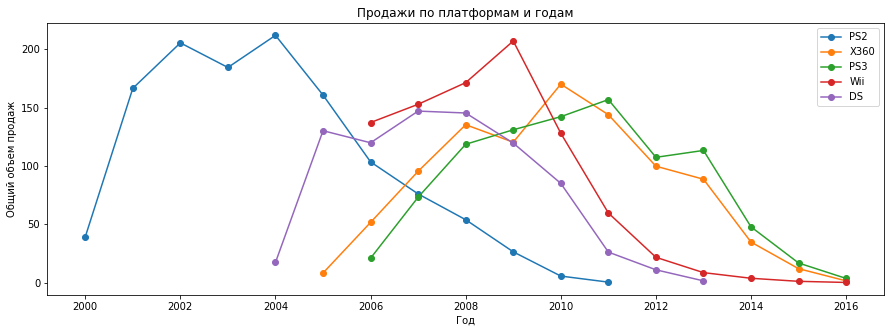

In [43]:
plt.figure(figsize=(15,5))

# Построим распределение продаж по годам для каждой из топ-5 платформ

for platform in top_platforms:
    plt.plot(
        top_platforms_sales[top_platforms_sales['platform'] == platform]['year_of_release'],
        top_platforms_sales[top_platforms_sales['platform'] == platform]['total_sales'],
        '-o',
        label=platform,
    )

plt.title('Продажи по платформам и годам')
plt.xlabel('Год')
plt.ylabel('Общий объем продаж')
plt.legend()
plt.show()

На основании графика мы смогли увивидеть ошибку в платформе DS и удалили его. Теперь график выглядит без аномалий.

In [44]:
# Группируем данные по платформе и находим минимальный и максимальный годы для каждой платформы
platform_years = top_platforms_sales.groupby('platform')['year_of_release'].agg(['min', 'max'])

# Вычисляем продолжительность жизни платформы как разницу между максимальным и минимальным годами
platform_years['lifespan'] = platform_years['max'] - platform_years['min']

# Отображаем результат
print(platform_years)

           min   max  lifespan
platform                      
DS        2004  2013         9
PS2       2000  2011        11
PS3       2006  2016        10
Wii       2006  2016        10
X360      2005  2016        11


In [45]:
average_lifespan = platform_years['lifespan'].mean()
print("Средний срок жизни платформы: ", average_lifespan)

Средний срок жизни платформы:  10.2


**Топовые платформы на основании суммы продаж за весь период являются PS2, X360, PS3, Wii, DS
По графику и на основании вычислений понятно, что средняя продолжительность существования платформы составляет 10 лет.**

### Лидеры платформ по количеству продаж игр

Определим актуальный период и на основании него проанализируем какие платформы лидируют по продажам (растут или падают). 

Выберем несколько потенциально прибыльных платформ.

**Актуальный период** возьмем с 2014 по 2016 включительно. 

Мы сосредоточены на самых последних тенденциях и изменениях в игровой индустрии, поэтому данные за последние 3 года (с 2014 по 2016 годы) вполне достаточные.

In [46]:
years = [2014, 2015, 2016]
filtered_df = datasets_games[datasets_games['year_of_release'].isin(years)]
filtered_df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1.0,-1.0,unknown,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,-1.0,-1.0,unknown,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,-1.0,-1.0,unknown,7.98


Построим боксплот для анализа разброса значений

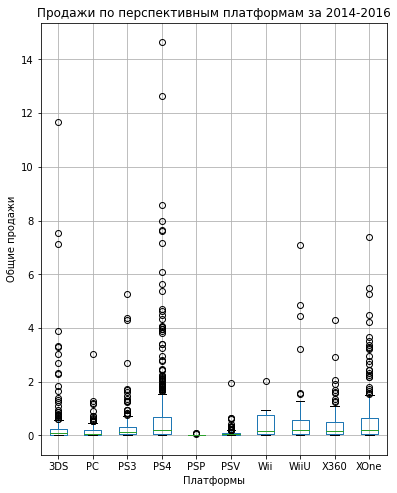

In [47]:
filtered_df.boxplot(column='total_sales', by='platform', figsize=(6,8))

plt.xlabel('Платформы')
plt.ylabel('Общие продажи')
plt.suptitle('') # Удаляем автоматически сгенерированный заголовок
plt.title('Продажи по перспективным платформам за 2014-2016')
plt.show()

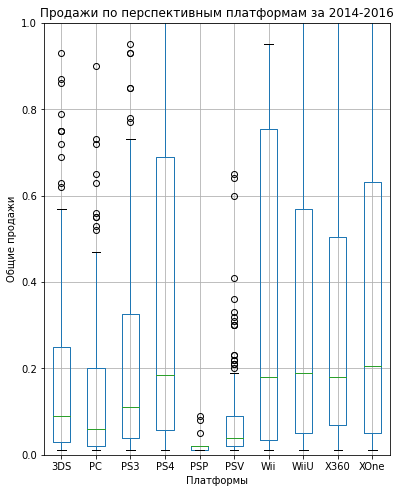

In [48]:
filtered_df.boxplot(column='total_sales', by='platform', figsize=(6,8))

plt.xlabel('Платформы')
plt.ylabel('Общие продажи')
plt.suptitle('') # Удаляем автоматически сгенерированный заголовок
plt.title('Продажи по перспективным платформам за 2014-2016')
plt.ylim(0, 1)

plt.show()

**На основании boxplot можно сделать вывод что наиболеее перспективными платформами являются:WiiU, XOne, PS4, так как их медиана выше, чем у других платформ за 2014-2016 год.**

Разброс продаж велик, что говорит что у платформы есть игры, которые хорошо продаются и которые плохо продаются.

Построим график продаж игр по платформе и проанализируем его

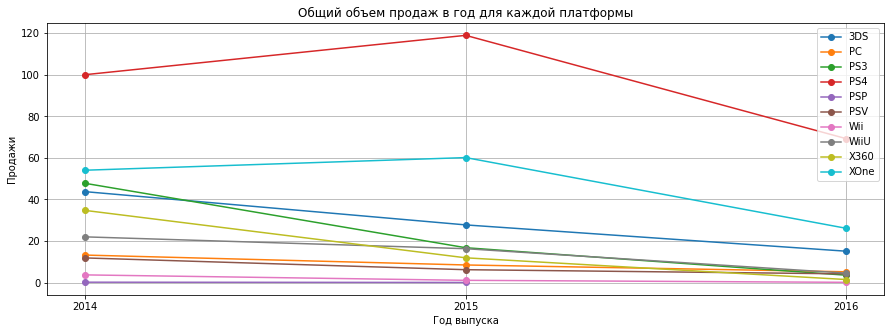

In [49]:
from matplotlib.ticker import MultipleLocator

# Предполагается, что filtered_df - это ваш DataFrame

grouped_df = filtered_df.groupby(['year_of_release', 'platform'])['total_sales'].sum().unstack()

fig, ax = plt.subplots(figsize=(15,5))

for column in grouped_df.columns:
    ax.plot(grouped_df[column], '-o', label=column)

ax.xaxis.set_major_locator(MultipleLocator(1))  # Устанавливаем интервал между отметками на оси X равным 1

ax.set_title('Общий объем продаж в год для каждой платформы')
ax.set_xlabel('Год выпуска')
ax.set_ylabel('Продажи')
ax.legend()
ax.grid(True)

plt.show()

**У всех платформ продажи игр падают. Наиболее высокие продажи у платформ в 2016 PS4,Xone,3DS.**

Одной из возможных причин падения продаж игр на всех платформах в 2016 году может быть насыщение рынка. С каждым годом на рынок выпускается все больше и больше игр, и у потребителей просто не хватает времени или денег, чтобы приобрести все из них. Кроме того, с увеличением количества игр увеличивается и конкуренция, поэтому некоторые игры просто не могут привлечь достаточное количество внимания.

Другой возможной причиной может быть смена тенденций в игровой индустрии. Возможно, в 2016 году больше людей начали переходить на мобильные игры или игры в браузере, которые обычно более доступны и не требуют больших вложений. Это могло привести к снижению продаж игр на традиционных игровых платформах.

В любом случае, без более детального анализа данных и дополнительной информации о том, что происходило в игровой индустрии и мире в целом в 2016 году, сложно сказать точно, что вызвало падение продаж.

Сделаем таблицу с продажами по годам по конкретной платформе

In [50]:
platform_sales_2014_till_2016 = filtered_df.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()
platform_sales_2014_till_2016

,platform,year_of_release,total_sales
0,3DS,2014,43.76
1,3DS,2015,27.78
2,3DS,2016,15.14
3,PC,2014,13.28
4,PC,2015,8.52
5,PC,2016,5.25
6,PS3,2014,47.76
7,PS3,2015,16.82
8,PS3,2016,3.60
9,PS4,2014,100.00


Выберем платформы у которых наиболее высокие продажи

In [51]:
top_platforms_2014_till_2016 = platform_sales.groupby('platform')['total_sales'].sum().nlargest(6).index
top_platforms_2014_till_2016

Index(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS'], dtype='object', name='platform')

**Наиболее потенциально прибыльные платформы за 2014-2016 PS4, XOne, 3DS, PS3, X360**

### Влияние отзывов пользователей и критиков на продажи платформ.

Выберем платформу с наибольшими продажами за период 2014-2016 гг. — PS4. Для нее построим диаграмму рассеяния и рассчитаем корреляцию между отзывами и объемом продаж. Затем сравним полученные выводы с данными по продажам игр на других платформах.


Анализ для платформы: PS4


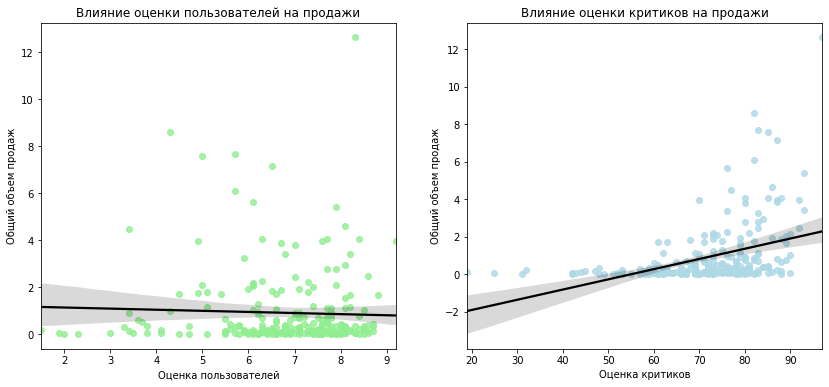

Коэффициент Пирсона на основании отзывов пользователей платформа PS4: -0.040131589472697356
Коэффициент Пирсона на основании отзывов критиков платформа PS4: 0.40266141068104083

Анализ для платформы: XOne


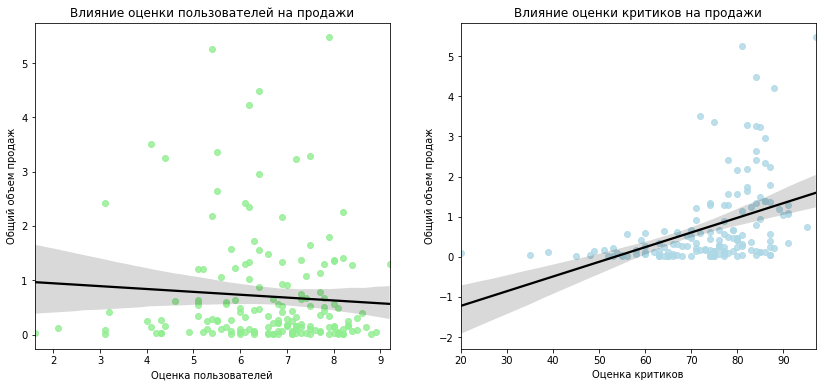

Коэффициент Пирсона на основании отзывов пользователей платформа XOne: -0.0703839280647581
Коэффициент Пирсона на основании отзывов критиков платформа XOne: 0.42867694370333226

Анализ для платформы: 3DS


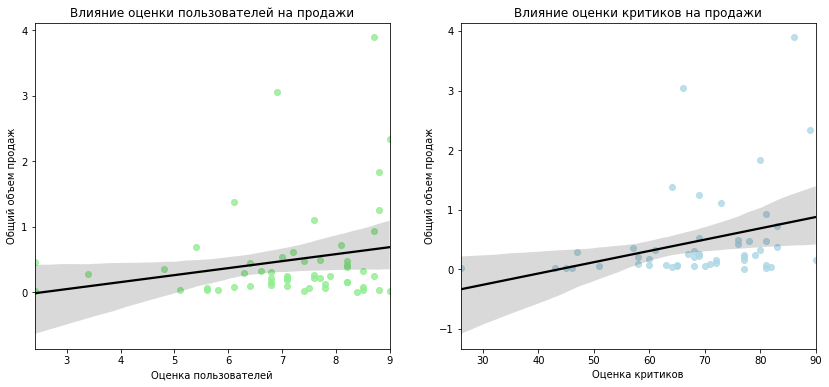

Коэффициент Пирсона на основании отзывов пользователей платформа 3DS: 0.2151932718527028
Коэффициент Пирсона на основании отзывов критиков платформа 3DS: 0.314117492869051

Анализ для платформы: PS3


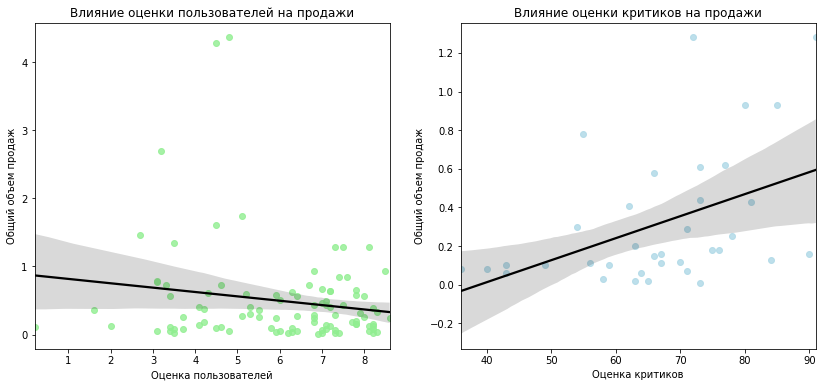

Коэффициент Пирсона на основании отзывов пользователей платформа PS3: -0.16676141347662118
Коэффициент Пирсона на основании отзывов критиков платформа PS3: 0.44657460493190704

Анализ для платформы: X360


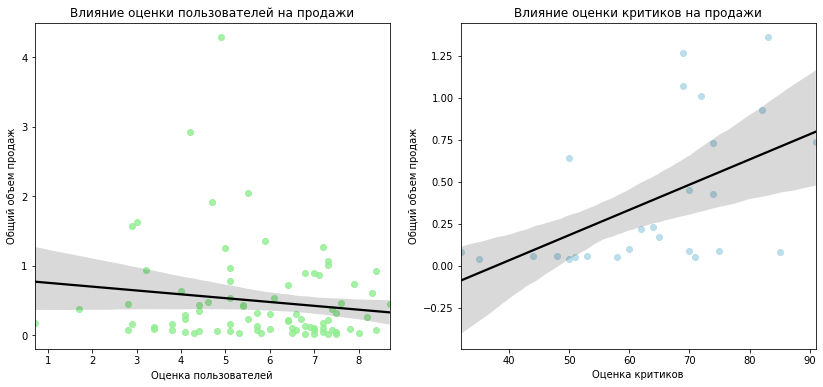

Коэффициент Пирсона на основании отзывов пользователей платформа X360: -0.138444570945665
Коэффициент Пирсона на основании отзывов критиков платформа X360: 0.5257228356581523

Анализ для платформы: WiiU


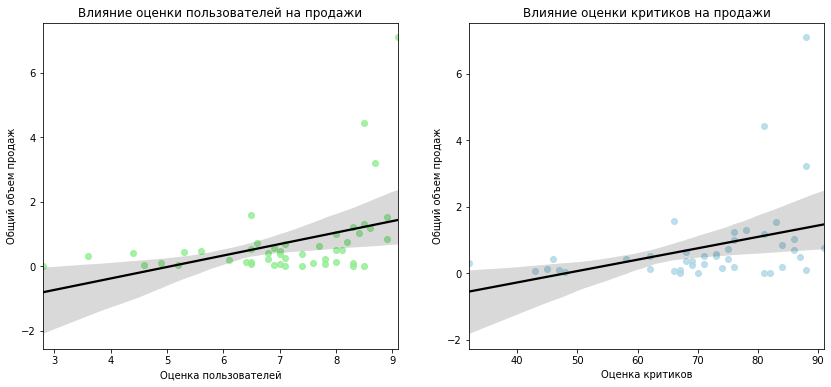

Коэффициент Пирсона на основании отзывов пользователей платформа WiiU: 0.40792645792170773
Коэффициент Пирсона на основании отзывов критиков платформа WiiU: 0.370201412480884


In [55]:
platforms = ['PS4','XOne', '3DS', 'PS3', 'X360', 'WiiU']
for platform in platforms:
    print(f"\nАнализ для платформы: {platform}")
    
    # Создаем подмножества данных для каждой платформы
    users_df = filtered_df[(filtered_df['platform'] == platform) & (filtered_df['user_score'] != -1.0)]
    critics_df = filtered_df[(filtered_df['platform'] == platform) & (filtered_df['critic_score'] != -1.0)]
    
    # Построим диаграммы рассеяния и вычислим коэффициенты корреляции Пирсона
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    sns.regplot(x='user_score', 
                y='total_sales', 
                data=users_df, 
                ax=axs[0], 
                line_kws={"color": "black"}, 
                color='lightgreen')
    
    axs[0].set_title('Влияние оценки пользователей на продажи')
    axs[0].set_xlabel('Оценка пользователей')
    axs[0].set_ylabel('Общий объем продаж')
    
    sns.regplot(x='critic_score', 
                y='total_sales', 
                data=critics_df, 
                ax=axs[1], 
                line_kws={"color": "black"}, 
                color='lightblue')
    
    axs[1].set_title('Влияние оценки критиков на продажи')
    axs[1].set_xlabel('Оценка критиков')
    axs[1].set_ylabel('Общий объем продаж')
    
    plt.show()
    # Коэффициенты корреляции Пирсона
    corr_user = users_df['user_score'].corr(users_df['total_sales'])
    corr_critic = critics_df['critic_score'].corr(critics_df['total_sales'])
    
    print(f"Коэффициент Пирсона на основании отзывов пользователей платформа {platform}: {corr_user}")
    print(f"Коэффициент Пирсона на основании отзывов критиков платформа {platform}: {corr_critic}")

На основе проведенного анализа, можно сделать следующие выводы:

**PS4**: Отзывы пользователей имеют незначительное отрицательное влияние на продажи (-0.04), в то время как отзывы критиков имеют умеренное положительное влияние (0.40).

**XOne**: Также как и на PS4, отзывы пользователей слабо влияют на продажи и имеют небольшой отрицательный коэффициент корреляции (-0.07), тогдакак отзывы критиков имеют умеренное положительное влияние (0.43).

**3DS**: Отзывы пользователей имеют слабое положительное влияние (0.21), а отзывы критиков - умеренное положительное влияние (0.31).

**PS3**: Отзывы пользователей имеют слабое отрицательное влияние (-0.17), в то время как отзывы критиков имеют умеренное положительное влияние (0.45).

**X360**: Отзывы пользователей имеют слабое отрицательное влияние (-0.14), тогда как отзывы критиков имеют умеренное положительное влияние (0.53).

**WiiU**: Отзывы пользователей имеют умеренное положительное влияние (0.41), а отзывы критиков - слабое положительное влияние (0.37).

**В целом, можно утверждать, что отзывы критиков, как правило, имеют большее влияние на продажи, чем отзывы пользователей.Но нельзя сказать, что именно они влиют на покупку игр**

### Распределение игр по жанрам

Проанализируем общее распределение игр по жанрам. Найдем самые прибыльные жанры

Определим выделяются ли жанры с высокими и низкими продажами

Вычислим продажи по жанрам.

In [57]:
# Суммирование продаж по жанрам
sales_by_genre = filtered_df.groupby('genre')['total_sales'].sum().sort_values(ascending=False)
sales_by_genre

genre
Action          199.36
Shooter         170.94
Sports          109.48
Role-Playing    101.44
Misc             37.55
Fighting         28.22
Racing           27.52
Platform         18.09
Adventure        17.55
Simulation       13.13
Strategy          3.96
Puzzle            2.21
Name: total_sales, dtype: float64

На первый взгляд может показаться, что самыми прибыльными жанрами стали Action и Shooter. Но для устойчивой прибыльности необходимы стабильные жанры. В имеющихся данных представлены продажи по жанрам для различных платформ, и если одна платформа с одной игрой в определённом жанре оказалась на вершине успеха, в то время как другие не смогли достичь таких же результатов, то данные будут искажены и будет казаться что именно этот жанр САМЫЙ популярный. Поэтому более разумным будет провести сравнение медианных продаж по жанрам и сделать диаграмму размах

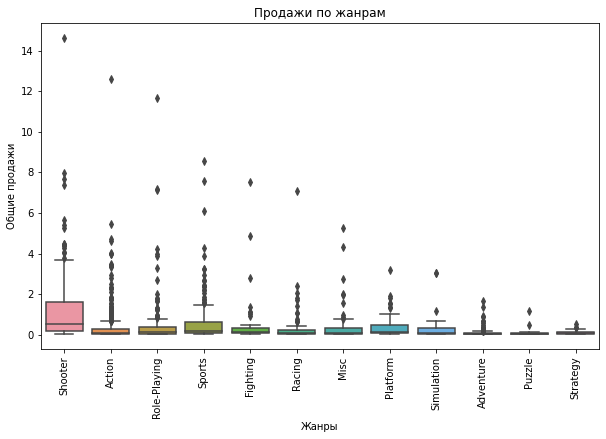

In [58]:
plt.figure(figsize=(10,6))
sns.boxplot(x="genre", 
            y="total_sales", 
            data=filtered_df)
plt.title('Продажи по жанрам')
plt.xlabel('Жанры')
plt.ylabel('Общие продажи')
plt.xticks(rotation=90) # поворачиваем подписи оси x для лучшей читаемости
plt.show()

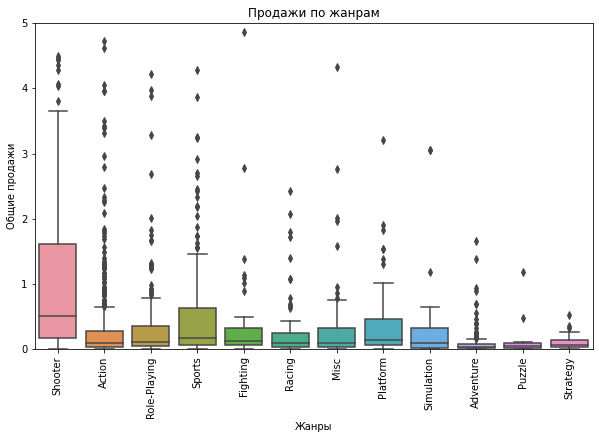

In [59]:
plt.figure(figsize=(10,6))
sns.boxplot(x="genre", 
            y="total_sales", 
            data=filtered_df)
plt.title('Продажи по жанрам')
plt.xlabel('Жанры')
plt.ylabel('Общие продажи')
plt.xticks(rotation=90) # поворачиваем подписи оси x для лучшей читаемости
plt.ylim(0, 5)
plt.show()

На основании диаграммы размаха мы видим, что мы ошибались. У жанра Action огромный разброс данных. Посчитаем медианные продажи

In [60]:
# Вычисление медианных продаж по жанрам
median_sales_by_genre = filtered_df.groupby('genre')['total_sales'].median().sort_values(ascending=False)
median_sales_by_genre

genre
Shooter         0.515
Sports          0.180
Platform        0.140
Fighting        0.125
Role-Playing    0.110
Simulation      0.100
Action          0.090
Misc            0.090
Racing          0.090
Strategy        0.060
Puzzle          0.045
Adventure       0.030
Name: total_sales, dtype: float64

Изучив распределение игр по жанрам, я заметила, что игры жанра Shooter являются наиболее прибыльными, показывая наибольший уровень продаж. Жанры Sports и Platform также показывают хорошие результаты.

В то же время, жанры Adventure, Puzzle и Strategy отстают, демонстрируя наименьший уровень продаж. Это может указывать на менее высокую популярность этих жанров среди игроков.

Таким образом, если целью является максимизация прибыли, стоит обратить внимание на разработку игр и пиар в жанрах Shooter, Sports и Platform.

Но более подробно рассмотрим дальше, так как популярность жанра может зависить от страны пользователя

## Портрет пользователя каждого региона

### Самые популярные платформы (топ-5) и жанры каждого региона (NA, EU, JP)

Посчитаем удельный вес каждой платформы и жанра в зависимости от региона, используя медианные значения, чтобы избежать искажений, вызванных выбросами.

Самые популярные платформы (топ-5) и популярные жанры (топ-5) NA, EU, JP

In [61]:
top5_na_platforms = filtered_df.groupby('platform')['na_sales'].median().sort_values(ascending=False)
top5_na_platforms[:5]

platform
X360    0.10
XOne    0.10
WiiU    0.09
PS4     0.05
Wii     0.04
Name: na_sales, dtype: float64

In [62]:
top5_na_platforms[5:].sum()

0.02

In [63]:
top5_na_platforms = filtered_df.groupby('platform')['na_sales'].median().sort_values(ascending=False)

others = top5_na_platforms[5:].sum()
top5_na_platforms = top5_na_platforms[:5]
top5_na_platforms.loc['Others'] = others

top5_na_genres = filtered_df.groupby('genre')['na_sales'].median().sort_values(ascending=False)
others, top5_na_genres = top5_na_genres[5:].sum(), top5_na_genres.head()
top5_na_genres.loc['Others'] = others

top5_eu_platforms = filtered_df.groupby('platform')['eu_sales'].median().sort_values(ascending=False)
others, top5_eu_platforms = top5_eu_platforms[5:].sum(), top5_eu_platforms.head()
top5_eu_platforms.loc['Others'] = others

top5_eu_genres = filtered_df.groupby('genre')['eu_sales'].median().sort_values(ascending=False)
others, top5_eu_genres = top5_eu_genres[5:].sum(), top5_eu_genres.head()
top5_eu_genres.loc['Others'] = others

top5_jp_platforms = filtered_df.groupby('platform')['jp_sales'].median().sort_values(ascending=False)
others, top5_jp_platforms = top5_jp_platforms[5:].sum(), top5_jp_platforms.head()
top5_jp_platforms.loc['Others'] = others

top5_jp_genres = filtered_df.groupby('genre')['jp_sales'].median().sort_values(ascending=False)
others, top5_jp_genres = top5_jp_genres[5:].sum(), top5_jp_genres.head()
top5_jp_genres.loc['Others'] = others

In [64]:
top5_na_platforms

platform
X360      0.10
XOne      0.10
WiiU      0.09
PS4       0.05
Wii       0.04
Others    0.02
Name: na_sales, dtype: float64

**Доли продаж по платформам**

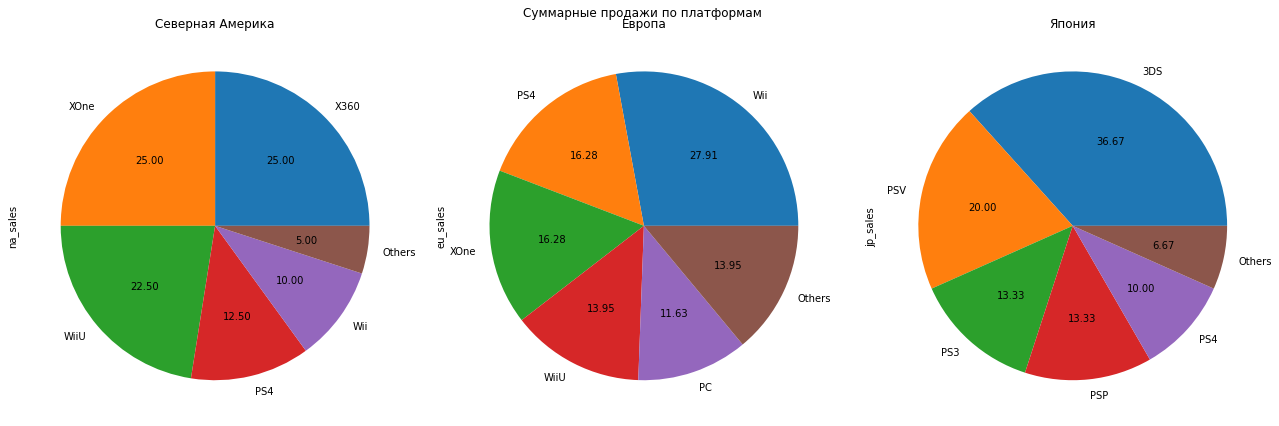

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
fig.suptitle('Суммарные продажи по платформам')

ax[0].set_title('Северная Америка')
top5_na_platforms.plot(ax=ax[0], kind='pie', autopct='%.2f', normalize=True)

ax[1].set_title('Европа')
top5_eu_platforms.plot(ax=ax[1], kind='pie', autopct='%.2f', normalize=True)

ax[2].set_title('Япония')
top5_jp_platforms.plot(ax=ax[2], kind='pie', autopct='%.2f', normalize=True)

plt.tight_layout()
plt.show()

**Доли продаж по жанрам**

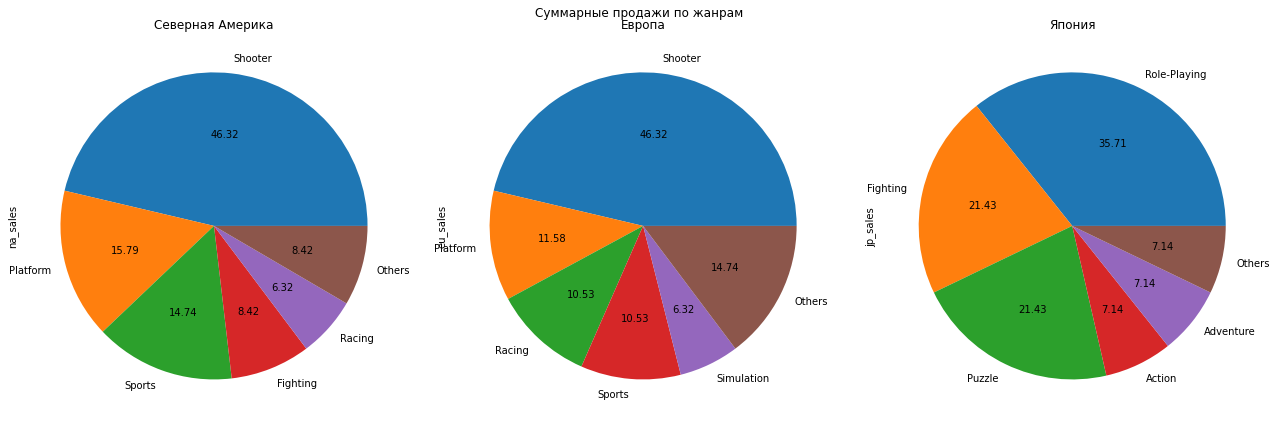

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
fig.suptitle('Суммарные продажи по жанрам')

ax[0].set_title('Северная Америка')
top5_na_genres.plot(ax=ax[0], kind='pie', autopct='%.2f', normalize=True)

ax[1].set_title('Европа')
top5_eu_genres.plot(ax=ax[1], kind='pie', autopct='%.2f', normalize=True)

ax[2].set_title('Япония')
top5_jp_genres.plot(ax=ax[2], kind='pie', autopct='%.2f', normalize=True)

plt.tight_layout()
plt.show()

**Вывод:**

**На графике показано, что самый популярные платформы(топ 5)**

**В Америке** X360, XOne, WiiU, PS4, Wii

**В Европе** Wii, PS4, XOne, WiiU, PC

**В Японии** 3DS, PSV, PS3, PSP, PS4

**На графике показано, что самый популярные жанры (топ 5)**

**В Америке** Shooter, Platform, Sports, Fighting, Racing

**В Европе** Shooter, Platform, Racing, Sports, Simulation

**В Японии** Role-Playing, Action, Misc, Fighting, Shooter


### Влияние рейтинга ESRB на продажи в отдельном регионе

Оценим влияние рейтинга ESRB на продажи в каждом регионе. Посчитаем медианные продажи на основании рейтинга, так как какие-то игры может искуственно завышать рейтинг и посмотрим  какой рейтинг возраста более популярный

In [67]:
impact_ESRB_sales_na = filtered_df.groupby('rating')['na_sales'].median().sort_values(ascending=False).to_frame()
impact_ESRB_sales_eu = filtered_df.groupby('rating')['eu_sales'].median().sort_values(ascending=False).to_frame()
impact_ESRB_sales_jp = filtered_df.groupby('rating')['jp_sales'].median().sort_values(ascending=False).to_frame()
display(impact_ESRB_sales_na)
display(impact_ESRB_sales_eu)
display(impact_ESRB_sales_jp)

,na_sales
rating,
M,0.12
E10+,0.10
E,0.05
T,0.03
unknown,0.00


,eu_sales
rating,
M,0.12
E10+,0.09
E,0.05
T,0.04
unknown,0.00


,jp_sales
rating,
unknown,0.02
T,0.01
E,0.00
E10+,0.00
M,0.00


Исходя из представленных данных, я могу сделать вывод, что рейтинг ESRB действительно влияет на продажи видеоигр в разных регионах.

**Северная Америка и Европа:** В этих регионах игры с рейтингом "M" (Mature, для лиц старше 17 лет) имеют наибольшую медиану продаж (0.12), что указывает на популярность игр для взрослой аудитории. Игры с рейтингами "E10+" (Everyone 10 and older) и "E" (Everyone) также имеют значительную медиану продаж. Игры с рейтингом "T" (Teen, для подростков 13-19 лет) имеют меньшую медиану продаж.

Однако в Японии (JP) ситуация иная. Игры с неизвестным рейтингом имеют наивысшие продажи. Это может быть связано с тем, что многие японские игры не проходят процесс рейтинговой классификации ESRB, поскольку ESRB является специфическим для Северной Америки и Европы органом по классификации игр.

**Таким образом, можно утверждать, что рейтинг ESRB влияет на продажи видеоигр в разных регионах, но этот эффект не является однозначным и зависит от конкретного региона.**

## Проверка гипотез

### Гипотеза о cредних пользовательских рейтингов платформ Xbox One и PC 

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

**H0**: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые; 

**H1**:Средние пользовательские рейтинги платформ Xbox One и PC разные

Статистическую значимость возьмем за 5 процентов


In [68]:
from scipy import stats

# Отфильтровываем данные
xbox_one_ratings = filtered_df[(filtered_df['platform'] == 'XOne') & (filtered_df['user_score']!=-1)]['user_score']
pc_ratings = filtered_df[(filtered_df['platform'] == 'PC') & (filtered_df['user_score']!=-1)]['user_score']

# Убедимся, что выборки не пусты
if xbox_one_ratings.empty or pc_ratings.empty:
    print('Одна из выборок пуста, проверьте данные')
else:
    # Выполняем t-тест
    t, p = stats.ttest_ind(xbox_one_ratings, 
                           pc_ratings, 
                           equal_var=False)

    # Выводим результат
    print('t =', t)
    print('p =', p)

    # Выбираем уровень значимости
    alpha = 0.05

    if p < alpha:
        print('Отвергаем нулевую гипотезу, средние пользовательские рейтинги платформ Xbox One и PC разные')
    else:
        print('Не отвергаем нулевую гипотезу, средние пользовательские рейтинги платформ Xbox One и PC одинаковые')

t = 1.577760647447497
p = 0.11601398086668832
Не отвергаем нулевую гипотезу, средние пользовательские рейтинги платформ Xbox One и PC одинаковые


При формулировании нулевой гипотезы (H0), я исходила из предположения о том, что нет значительных различий между сравниваемыми группами. В нашем случае, я утверждаю, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Альтернативная гипотеза (H1), в свою очередь, представляет собой утверждение, противоположное нулевой гипотезе. Здесь я предполагаю, что средние пользовательские рейтинги платформ Xbox One и PC разные.

Для проверки этих гипотез я применила t-тест Стьюдента для независимых выборок. Я выбрала именно этот тест, поскольку он позволяет оценить, есть ли статистически значимые различия между средними значениями двух независимых выборок. В нашем контексте, пользовательские рейтинги для игр на платформах Xbox One и PC представляют собой две отдельные выборки, которые я хочу сравнить.

Параметр equal_var=False указывает на использование версии t-теста, которая не предполагает равенства дисперсий исследуемых групп. Это делает тест более надежным, если мы не уверены, что дисперсии в наших выборках одинаковы.

Наконец, я использую уровень значимости (или альфа) равный 0.05, что означает вероятность ошибки первого рода 5%. Если полученное p-значение оказывается меньше этого уровня значимости, я отвергаю нулевую гипотезу.

### Гипотеза о средних пользовательских рейтингов жанров Action  и Sports 

Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

**H0**: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые.

**H1**: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

Статистическую значимость возьмем за 5 процентов

In [69]:
# Отфильтровываем данные
action_ratings = filtered_df[(filtered_df['genre'] == 'Action') & (filtered_df['user_score']!=-1)]['user_score']
sports_ratings = filtered_df[(filtered_df['genre'] == 'Sports') & (filtered_df['user_score']!=-1)]['user_score']

# Убедимся, что выборки не пусты
if action_ratings.empty or sports_ratings.empty:
    print('Одна из выборок пуста, проверьте данные')
else:
    # Выполняем t-тест
    t, p = stats.ttest_ind(action_ratings, 
                           sports_ratings, 
                           equal_var=False)

    # Выводим результат
    print('t =', t)
    print('p =', p)

    # Выбираем уровень значимости
    alpha = 0.05

    if p < alpha:
        print('Отвергаем нулевую гипотезу, средние пользовательские рейтинги жанров Action и Sport разные')
    else:
        print('Не отвергаем нулевую гипотезу, средние пользовательские рейтинги жанров Action и Sport одинаковые')

t = 8.384614718486121
p = 1.1825550382644557e-14
Отвергаем нулевую гипотезу, средние пользовательские рейтинги жанров Action и Sport разные


При формулировании нулевой гипотезы (H0), я предположила, что нет значительных различий между сравниваемыми группами. В данном случае, я утверждаю, что средние пользовательские рейтинги для игр жанров Action и Sports одинаковые.

Альтернативная гипотеза (H1), с другой стороны, представляет собой утверждение, противоположное нулевой гипотезе. Здесь я предполагаю, что средние пользовательские рейтинги для игр жанров Action и Sports разные.

Для проверки этих гипотез я применила t-тест Стьюдента для независимых выборок. Я выбрала именно этот тест, потому что он позволяет оценить, есть ли статистически значимые различия между средними значениями двух независимых выборок. В нашем контексте, пользовательские рейтинги для игр жанров Action и Sports представляют собой две отдельные выборки, и я хотела сравнить их средние значения.

Я использовала параметр equal_var=False при проведении t-теста, что указывает на использование версии t-теста, которая не предполагает равенства дисперсий между исследуемыми группами. Это делает тест более надежным в случае, если мы не уверены, что дисперсии в наших выборках одинаковы.

Наконец, я определила уровень значимости (или альфа) равным 0.05. Это означает, что я принимаю вероятность ошибки первого рода в 5%. Если полученное p-значение оказывается меньше этого уровня значимости, то я отвергаю нулевую гипотезу.

## Общий вывод

**В процессе выполнения этой работы я сделала следующее:**

1. Внимательно изучила таблицу, обнаружила аномалии и пропущенные значения.

2. Произвела предобработку данных в таблице: изменила названия столбцов, заполнила пробелы, удалила дубликаты расчитала общкее количество продаж игр по регионам.

3. Провела детальный анализ данных и подготовила актуальную информацию.

4. Создала портреты пользователей для различных регионов продаж.

5. Провела проверку гипотез.

Все эти этапы были важными шагами в анализе и понимании данных, что позволило мне сделать выводы и рекомендации по продажам игр в разных регионах и на что конкретно потратить рекламные деньги.

**Для максимизации прибыли необходимо учитывать уникальные характеристики каждого региона.** Специфические предпочтения в платформах, жанрах и возрастных категориях игр в каждом регионе играют значительную роль в популярности игры. Понимание этих особенностей помогает нам лучше адаптировать наше предложение для каждого отдельного рынка.  Поэтому на основании анализа:

**В Северной Америке**	стоит выбирать платформы Xone, X360/ жанр Shooter / возрастная категория игры M

**В Европе стоит выбирать платформы** Wii, PS4 / жанр Shooter/ возрастная категория игры M

**В Японии стоит выбирать платформы** 3DS, PSV/ жанр Role-playing/по возрастной категории пользователей нет данных

In [70]:
table_recommendations = {
    'Название региона': ['Северная Америка', 'Европа', 'Япония'],
    'Платформы': ['Xone, X360', 'Wii, PS4', '3DS, PSV'],
    'Жанры': ['Shooter', 'Shooter', 'Role-playing'], 
    'Рейтинг': ['M', 'M', 'Нет данных']
}

table_recommendations = pd.DataFrame(table_recommendations)
table_recommendations = table_recommendations.set_index('Название региона')
table_recommendations = table_recommendations.style.set_properties(**{'text-align': 'center'})
table_recommendations

,Платформы,Жанры,Рейтинг
Название региона,,,
Северная Америка,"Xone, X360",Shooter,M
Европа,"Wii, PS4",Shooter,M
Япония,"3DS, PSV",Role-playing,Нет данных


В целом, можно утверждать, что отзывы критиков, как правило, имеют большее влияние на продажи, чем отзывы пользователей.Но нельзя сказать, что именно они влиют на покупку игр. Поэтому акцентрировать на это внимание не нужно.